In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### Create a Sklean Transformation Pipeline

In [2]:
# import Data for model
# Specify the path to the Parquet file
parquet_file_path = 'data\data_to_model\data_model.parquet'  # Update with the correct file path

# Read the Parquet file into a DataFrame
# Use 'pyarrow' as the engine if you saved it with that engine
df = pd.read_parquet(parquet_file_path, engine='fastparquet')  
df

,dayofweek,time,length,delay,international
index,,,,,
0,2,15,205,1,1
1,2,15,222,1,1
2,2,20,165,1,1
3,2,20,195,1,1
4,2,30,202,0,1
...,...,...,...,...,...
539378,4,1439,326,0,1
539379,4,1439,305,0,1
539380,4,1439,255,0,1


In [3]:
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64']).columns
bin_cols = df.select_dtypes(include=['int8']).columns.drop('delay')

cat_cols, num_cols, bin_cols

(Index(['dayofweek'], dtype='object'),
 Index(['time', 'length'], dtype='object'),
 Index(['international'], dtype='object'))

In [4]:
# Create a ColumnTransformer to apply StandardScaler to numerical features and OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols),
    ],
    remainder='passthrough'  # Include 'bin1' as a numerical feature without scaling or encoding
)

# Create a scikit-learn pipeline
pipeline = Pipeline([
    # Apply the preprocessor (ColumnTransformer)
    ('preprocessor', preprocessor),
    # Add any additional steps to your pipeline, such as a classifier or regressor
    ('classifier', LogisticRegression(),)
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['time', 'length'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['dayofweek'], dtype='object'))])),
                ('classifier', LogisticRegression())])

# Split data

In [5]:
X = df[['dayofweek', 'time', 'length','international']]
y = df['delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((383131, 4), (95783, 4), (383131,), (95783,))

In [6]:
df_test = pd.DataFrame(data=X_test, columns=X_test.columns)
df_test['delay'] = y_test

# Train model

In [7]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['time', 'length'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['dayofweek'], dtype='object'))])),
                ('classifier', LogisticRegression())])

In [8]:
pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [19]:
pipeline.named_steps['classifier'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [9]:
pipeline.fit(X_train, y_train)
model = pipeline.named_steps['classifier']
pipeline.named_steps['preprocessor']

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 Index(['time', 'length'], dtype='object')),
                                ('cat', OneHotEncoder(drop='first'),
                                 Index(['dayofweek'], dtype='object'))])

## Model interpretation

In [8]:
W0 = model.intercept_[0]
W0

-0.15313227651568512

In [9]:
coef = model.coef_[0]
coef

array([ 0.31703869,  0.08010202, -0.05397459,  0.03106884, -0.04981722,
       -0.17846149, -0.24429649, -0.07505026,  0.03128791])

In [10]:
pipeline.predict_proba(X_test)

array([[0.57613238, 0.42386762],
       [0.65819363, 0.34180637],
       [0.59055288, 0.40944712],
       ...,
       [0.59624774, 0.40375226],
       [0.53851571, 0.46148429],
       [0.50071747, 0.49928253]])

In [10]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1].round(3)

In [11]:
churn_decision = (y_pred_prob >= 0.5)
churn_decision

array([False, False, False, ..., False, False, False])

In [12]:
### % of prediction match
(y_test == churn_decision.astype(int)).mean()

0.5664261925393859

In [13]:
df_test['churn'] = churn_decision.astype(int)
df_test['correct'] = df_test['delay'] == df_test['churn']
df_test['churn_prob'] = y_pred_prob

df_test

,dayofweek,time,length,international,delay,churn,correct,churn_prob
index,,,,,,,,
5731,2,635,115,1,1,0,False,0.424
471003,1,453,65,1,0,0,True,0.342
90826,0,620,105,1,1,0,False,0.409
362547,1,1134,95,1,1,1,True,0.539
534748,4,925,142,1,0,0,True,0.461
...,...,...,...,...,...,...,...,...
69142,6,418,165,1,0,0,True,0.353
86021,0,377,138,1,0,0,True,0.353
164096,4,749,112,1,0,0,True,0.404


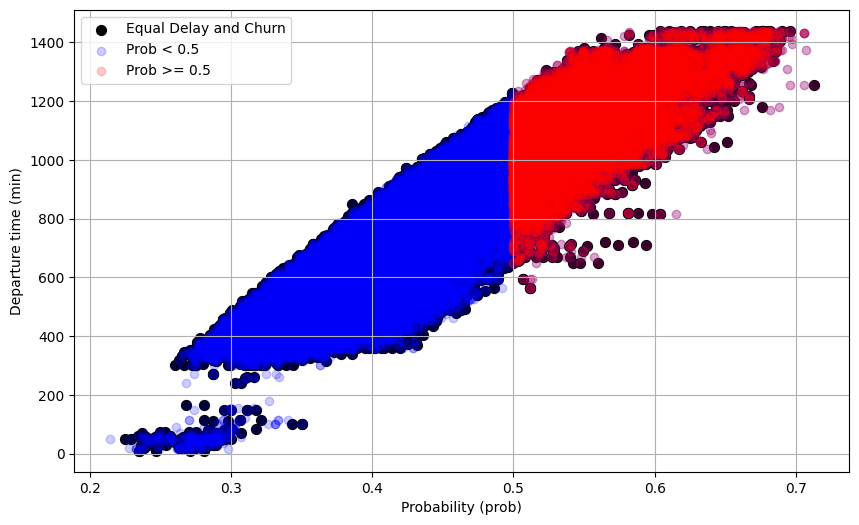

In [14]:
delay_points = df_test[df_test['churn_prob'] >= 0.5]
tps_points = df_test[(df_test['delay'] == df_test['churn'])]
fly_time = df_test['time']
delay_prob = df_test['churn_prob']

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed


plt.scatter(tps_points['churn_prob'], tps_points['time'], color='black', label='Equal Delay and Churn', s=50)
plt.scatter(delay_prob, fly_time,  color='blue', label='Prob < 0.5', alpha=0.2)
plt.scatter(delay_points['churn_prob'], delay_points['time'], color='red', label='Prob >= 0.5', alpha=0.2)


plt.ylabel('Departure time (min)')
plt.xlabel('Probability (prob)')
plt.legend()
plt.grid(True)
plt.show()


# Model interpolation

In [15]:
# Assuming you have trained the logistic regression model using the provided pipeline and your preprocessed data is stored in X_train

# Get the fitted logistic regression model from the pipeline
logistic_regression_model = pipeline.named_steps['classifier']

# Get the coefficients (weights) of the model
coef = logistic_regression_model.coef_[0]

# Get the column names for the preprocessed data after one-hot encoding
preprocessor = pipeline.named_steps['preprocessor']
column_names = []

# Loop through transformers and collect the feature names
for name, transformer, features in preprocessor.transformers_:
    print(name, transformer,features )
    if name != 'cat':
        # If the transformer is StandardScaler, use the original feature names
        column_names.extend(features)
    elif name == 'cat':
        # If the transformer is OneHotEncoder, get the feature names manually
        cat_encoder = transformer
        cat_feature_names = list(cat_encoder.get_feature_names_out(input_features=features))
        column_names.extend(cat_feature_names)

# Create a dictionary mapping feature names to their coefficients
feature_coefficients = {column: coef_value for column, coef_value in zip(column_names, coef)}

# Print or use the feature_coefficients dictionary
feature_coefficients

num StandardScaler() Index(['time', 'length'], dtype='object')
cat OneHotEncoder(drop='first') Index(['dayofweek'], dtype='object')
remainder passthrough [3]


{'time': 0.3170386901329221,
 'length': 0.08010201914141064,
 'dayofweek_1': -0.05397459139662084,
 'dayofweek_2': 0.031068835980899368,
 'dayofweek_3': -0.049817221693908224,
 'dayofweek_4': -0.17846148882302837,
 'dayofweek_5': -0.24429648790511746,
 'dayofweek_6': -0.07505026218738826,
 3: 0.031287906790191444}

In [16]:
import numpy as np
def sigmoid(z):
    """definition of probability on the churn case, to be TRUE"""
    return 1 / (1 + np.exp(-z))

sigmoid(W0 + (-0.24))

0.40296349685103894

### base line model evaluation

In [17]:
def model_evaluation(y_test, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

    # Calculate and print various evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Create and display a confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    result_dict = {

        # Print the evaluation metrics
        "Accuracy": accuracy.round(2),
        "Precision": precision.round(2),
        "Recall": recall.round(2),
        "F1-Score": f1.round(2),
        "ROC-AUC Score": roc_auc.round(2),
        "Confusion Matrix":conf_matrix
    }

    return result_dict

In [18]:
y_pred = pipeline.predict(X_train)
model_evaluation(y_test=y_train, y_pred=y_pred)

{'Accuracy': 0.57,
 'Precision': 0.53,
 'Recall': 0.36,
 'F1-Score': 0.43,
 'ROC-AUC Score': 0.55,
 'Confusion Matrix': array([[154641,  55275],
        [109993,  63222]], dtype=int64)}

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

y_pred = pipeline.predict(X_test)

y_pred_prob = pipeline.predict_proba(X_test)[:, 1].round(3)


# Calculate and print various evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Create and display a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.57
Precision: 0.53
Recall: 0.36
F1-Score: 0.43
ROC-AUC Score: 0.55
Confusion Matrix:
[[38444 13893]
 [27655 15791]]


Accuracy: 0.57
Precision: 0.53
Recall: 0.36
F1-Score: 0.43
ROC-AUC Score: 0.55
Confusion Matrix:
[[38444 13893]
 [27655 15791]]

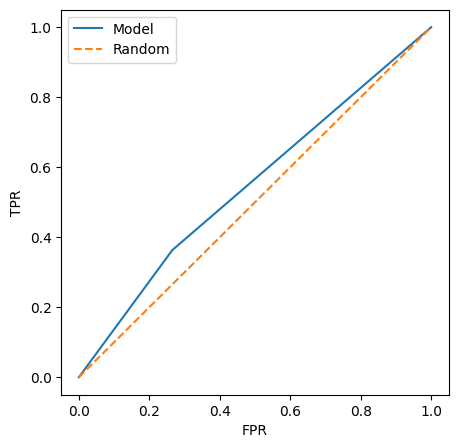

In [20]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0,1],[0,1], label='Random', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [21]:
## Accuracy over different thresholds

thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    score = accuracy_score(y_test, y_pred_prob >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)
    


0.00 0.454
0.05 0.454
0.10 0.454
0.15 0.454
0.20 0.454
0.25 0.454
0.30 0.460
0.35 0.505
0.40 0.553
0.45 0.571
0.50 0.566
0.55 0.556
0.60 0.547
0.65 0.546
0.70 0.546
0.75 0.546
0.80 0.546
0.85 0.546
0.90 0.546
0.95 0.546
1.00 0.546


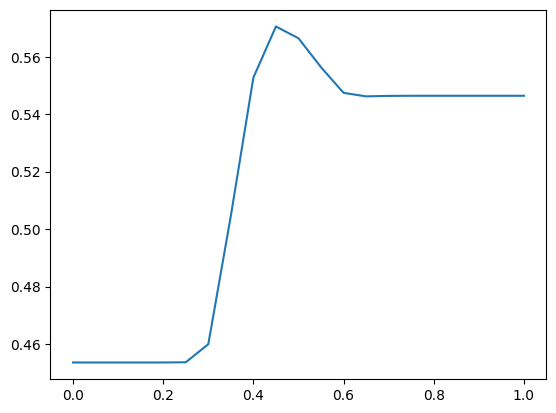

In [22]:
plt.plot(thresholds, scores)

In [23]:
from collections import Counter
Counter(y_test)

Counter({1: 43446, 0: 52337})

In [24]:
y_test.mean()

0.45358779741707816

# Grid Search Pipeline

In [25]:
from sklearn.model_selection import GridSearchCV

# Create a ColumnTransformer to apply StandardScaler to numerical features and OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols),
    ],
    remainder='passthrough'  # Include 'bin1' as a numerical feature without scaling or encoding
)

# Create a scikit-learn pipeline with preprocessing and Logistic Regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply the preprocessor (ColumnTransformer)
    ('classifier', LogisticRegression(solver='liblinear'))  # Add Logistic Regression as the classifier
])

# Define a hyperparameter grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 10],  # Regularization parameter
    'classifier__max_iter': [100, 500, 1000],  # Maximum number of iterations
    'classifier__penalty': ['l1', 'l2']

}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=3)  # You can adjust the number of cross-validation folds (cv)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions using the best estimator
y_pred = best_estimator.predict(X_test)

# This gets the predicted probabilities
y_pred_proba = best_estimator.predict_proba(X_test)  

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Calculate and print various evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Create and display a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Best Hyperparameters: {'classifier__C': 0.5, 'classifier__max_iter': 500, 'classifier__penalty': 'l1'}
Accuracy: 0.57
Precision: 0.53
Recall: 0.36
F1-Score: 0.43
ROC-AUC Score: 0.55
Confusion Matrix:
[[38440 13897]
 [27654 15792]]


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Best Hyperparameters: {'classifier__C': 0.5, 'classifier__max_iter': 100}
Accuracy: 0.57
Precision: 0.53
Recall: 0.36
F1-Score: 0.43
ROC-AUC Score: 0.55
Confusion Matrix:
[[38444 13893]
 [27655 15791]]

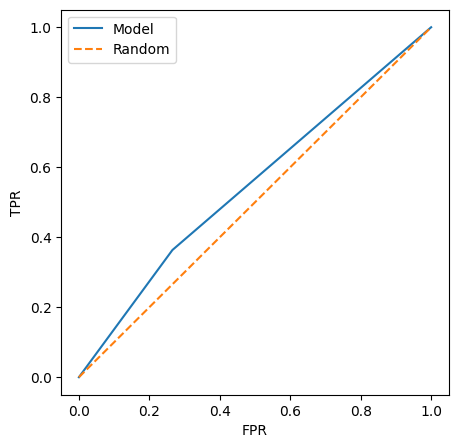

In [27]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0,1],[0,1], label='Random', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

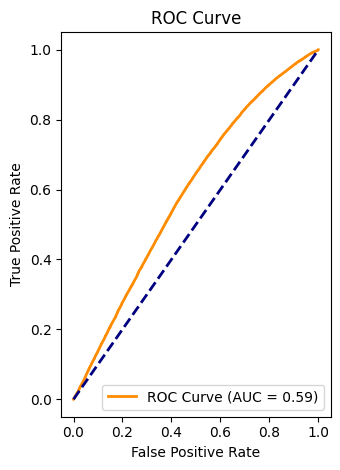

In [28]:
# Create ROC Curve PROBA
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

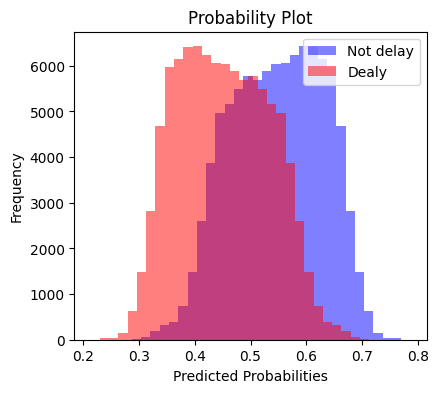

In [29]:
# Plot Probability Histograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[:, 0], bins=30, label='Not delay', alpha=0.5, color='blue')
plt.hist(y_pred_proba[:, 1], bins=30, label='Dealy', alpha=0.5, color='red')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Probability Plot')
plt.legend()